# Introduction to Data Science and Machine Learning

<p align="center">
    <img width="699" alt="image" src="https://user-images.githubusercontent.com/49638680/159042792-8510fbd1-c4ac-4a48-8320-bc6c1a49cdae.png">
</p>

---

### Import libraries


In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, roc_auc_score
import joblib

import xgboost as xgb

from utils.plottings import plot_learning_curve
from utils.helpers_Garden import visualize_tree, plot_tree_interactive, randomized_tree_interactive, visualize_classifier

%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams['figure.figsize'] = (25.0, 10.0)
sns.set()

## Gradient Boosting
Gradient boosting is one of the most powerful techniques for building predictive models.

The basic idea is really simple: a weak learner can be modified to become better.

Consider a _weak learner_, _i.e._ a learner performing only slightly better than random choice. 
One can leave the examples the learner can handle well and focus only on developing new weak learns to handle the remaining difficult observations.

<p align="center">
    <img width="1200" src="https://media.geeksforgeeks.org/wp-content/uploads/20210707140911/Boosting.png">
</p>

> _The idea is to use the weak learning method several times to get a succession of hypotheses, each one refocused on the examples that the previous ones found difficult and misclassified._

Another nice definition of boosting is 

> _Boosting refers to this general problem of producing a very accurate prediction rule by combining rough and moderately inaccurate rules-of-thumb._

### AdaBoost

The first realization of boosting that saw great success in application was [Adaptive Boosting](https://en.wikipedia.org/wiki/AdaBoost) or [AdaBoost](https://blog.paperspace.com/adaboost-optimizer/#:~:text=AdaBoost%20is%20an%20ensemble%20learning,turn%20them%20into%20strong%20ones.) for short.

The weak learners in AdaBoost are decision trees with a single split, called decision stumps for their shortness.

For example, an AdaBoost classifier is a learner that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of instances are adjusted according to the error of the current prediction.

In [2]:
# A simple example of using the AdaBoostClassifier

X, y = make_classification(n_samples=1000,
                            n_features=4,
                            n_informative=2,
                            n_redundant=0, 
                            random_state=0, 
                            shuffle=False)
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X, y)

AdaBoostClassifier(n_estimators=100, random_state=0)

In [3]:
clf.score(X, y)

0.983

## XGBoost

### XGBoost as ensemble learner

Unlike many other algorithms, XGBoost is an ensemble learning algorithm meaning that it combines the results of many models, called base learners to make a prediction.

Just like in Random Forests, XGBoost uses Decision Trees as base learners.

However, the trees used by XGBoost are a bit different than traditional decision trees. They are called CART trees (Classification and Regression trees) and instead of containing a single decision in each “leaf” node, they contain real-value scores of whether an instance belongs to a group. After the tree reaches max depth, the decision can be made by converting the scores into categories using a certain threshold.

For details, we strongly advise to look at this great video about XGBoost.

<p align="center">
    <a href = "https://www.youtube.com/watch?v=OtD8wVaFm6E&list=PLblh5JKOoLULU0irPgs1SnKO6wqVjKUsQ&index=2"><iframe width="420" height="315" 
        src="https://www.youtube.com/watch?v=OtD8wVaFm6E&list=PLblh5JKOoLULU0irPgs1SnKO6wqVjKUsQ&index=2">
    </iframe></a>
</p>

### How to preprocess your datasets for XGBoost

Apart from basic data cleaning operations, there are some requirements for XGBoost to achieve top performance. Mainly:

1. Numeric features should be scaled;
2. Categorical features should be encoded.

#### An example for XGBOOST

We will use the [Australia rain dataset](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package), with one goal in mind, that is predict next-day rain by training classification models on the target variable `RainToday`.

In [4]:
df = pd.read_csv("datasets/weatherAUS.csv")
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [5]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

The dataset contains weather measures of $10$ years from multiple weather stations in Australia. 
You can either predict whether it will rain tomorrow or today, so there are two targets in the dataset named `RainToday`, `RainTomorrow`.

Since we will only be predicting for `RainToday`, we will drop the other one along with some other features that won't be necessary.

In [6]:
cols_to_drop = ["Date", "Location", "RainTomorrow", "Rainfall"]

df.drop(cols_to_drop, axis=1, inplace=True)

Note that dropping the `Rainfall` column is a must because it records the amount of rain in millimeters.
Since we want to predict whether it will rain today this is an information we cannot use.

Next, let’s deal with missing values starting by looking at their proportions in each column.

In [7]:
missing_props = df.isna().mean(axis=0)
missing_props

MinTemp          0.010209
MaxTemp          0.008669
Evaporation      0.431665
Sunshine         0.480098
WindGustDir      0.070989
WindGustSpeed    0.070555
WindDir9am       0.072639
WindDir3pm       0.029066
WindSpeed9am     0.012148
WindSpeed3pm     0.021050
Humidity9am      0.018246
Humidity3pm      0.030984
Pressure9am      0.103568
Pressure3pm      0.103314
Cloud9am         0.384216
Cloud3pm         0.408071
Temp9am          0.012148
Temp3pm          0.024811
RainToday        0.022419
dtype: float64

We adopt such a rule: _If the proportion is higher than $40\%$ we will drop the column._

In [8]:
over_threshold = missing_props[missing_props >= 0.4]
over_threshold

Evaporation    0.431665
Sunshine       0.480098
Cloud3pm       0.408071
dtype: float64

Three columns contain more than 40% missing values. We are going to drop them.

In [9]:
df.drop(over_threshold.index, 
          axis=1, 
          inplace=True)

Now, before we move on to preprocessing and then training pipelines, let’s divide the data into feature and target arrays beforehand.

In [10]:
X = df.drop("RainToday", axis=1) # Features, note: This is a DataFrame
y = df.RainToday.map({'Yes': 1, 'No': 0}) # Target, note: This is a Series

Next, there are both categorical and numeric features. We will build two separate pipelines and combine them later.

* For the __categorical features__, we impute the missing values with the _mode_ of the column and encode them with _One-Hot encoding_.
* For the __numeric features__, we choose the _mean_ as an imputer and `StandardScaler` so that the features have $0$ mean and a variance of $1$.

In [11]:
categorical_pipeline = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("oh-encode", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ]
)
numeric_pipeline = Pipeline(
    steps=[("impute", SimpleImputer(strategy="mean")), 
           ("scale", StandardScaler())]
)

Finally, we will combine the two pipelines with a `ColumnTransformer`. To specify which columns the pipelines are designed for, we should first isolate the categorical and numeric feature names.

In [12]:
cat_cols = X.select_dtypes(exclude="number").columns # Select categorical columns
num_cols = X.select_dtypes(include="number").columns # Select numerical columns

full_processor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, num_cols),
        ("categorical", categorical_pipeline, cat_cols),
    ]
)

We are now ready to train the XGBOOST classifier, that familiarly follows the known and loved fit-predict pattern of scikit-learn models.

In [13]:
y = SimpleImputer(strategy="most_frequent").fit_transform(
    y.values.reshape(-1, 1)
) # Impute to not have missing values

# Apply preprocessing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42, test_size=0.2
)

X_train_processed = full_processor.fit_transform(X_train)
X_test_processed = full_processor.transform(X_test)

Now, we fit the classifier with default parameters and evaluate its performance.

In [14]:
# Init classifier
xgb_cl = xgb.XGBClassifier()

# Fit
xgb_cl.fit(X_train_processed, y_train)

# Predict
preds = xgb_cl.predict(X_test_processed)


print(f"Accuracy of the default model: {accuracy_score(y_test, preds)}")
print(f"Classification report: \n{classification_report(y_test, preds)}")

Accuracy of the default model: 0.8487556716623127
Classification report: 
              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91     22716
         1.0       0.70      0.54      0.61      6376

    accuracy                           0.85     29092
   macro avg       0.79      0.74      0.76     29092
weighted avg       0.84      0.85      0.84     29092



Even with default parameters, we got an $85\%$ accuracy which is reasonably good. However the class unbalance made our model not really good on class $1$. 
In the next sections, we will try to improve the model even further by using `GridSearchCV` offered by Scikit-learn.

In [15]:
# Let's have a look at the xgboost hyperparameters
print(xgb_cl.get_params())

{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': 0, 'gpu_id': -1, 'grow_policy': 'depthwise', 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_bin': 256, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 6, 'max_leaves': 0, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 0, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'sampling_method': 'uniform', 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}


It has quite a few as you can see. Even though, we achieved reasonably good results with the defaults, tuning the above parameters might result in a significant increase in performance. 
But before we get to tuning, let’s look at the overview of the most frequently tuned hyperparameters.

1. `learning_rate`: it specifies how quickly the model fits the residual errors by using additional base learners.

typical values: 0.01–0.2

2. `gamma`, `reg_alpha`, `reg_lambda`: these 3 parameters specify the values for 3 types of regularisation done by XGBoost - minimum loss reduction to create a new split, L1 reg on leaf weights, L2 reg leaf weights respectively.

typical values for `gamma`: 0 - 0.5 but highly dependent on the data.
typical values for `reg_alpha` and `reg_lambda`: 0 - 1 is a good starting point but again, depends on the data.

3. `max_depth` - how deep the tree's decision nodes can go. Must be a positive integer.

typical values: 1–10

4. `subsample` - fraction of the training set that can be used to train each tree. If this value is low, it may lead to underfitting or if it is too high, it may lead to overfitting.

typical values: 0.5–0.9

5. `colsample_bytree` - fraction of the features that can be used to train each tree. A large value means almost all features can be used to build the decision tree.

typical values: 0.5–0.9

The above are the main hyperparameters people often tune. 
It is perfectly OK if you do not understand them all completely but you can refer to this [post](http://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) which gives a thorough overview of how each of the above parameters works and how to tune them.

#### Grid search for XGBoost finetuning.

Finally, it is time to super-charge our XGBoost classifier. We will be using the GridSearchCV class from Scikit-learn which accepts possible values for desired hyperparameters and fits separate models on the given data for each combination of hyperparameters.

We will be tuning only a few of the parameters in two rounds because of how tuning is both computationally and time-expensive. Let’s create the parameter grid for the first round.

In [16]:
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.05, 0.01],
    "gamma": [0, 0.25, 1],
    "reg_alpha": [0, 0.5, 1],
    "reg_lambda": [0, 0.5, 1],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
} # Hyperparameter space grid

In [17]:
# Careful: This might take a while (~40 minutes).

# Init classifier
xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

# Init Grid Search
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

# Fit
_ = grid_cv.fit(X_train_processed, y_train)

joblib.dump(grid_cv, "models/xgb_cl_grid_cv.pkl")

['models/xgb_cl_grid_cv.pkl']

In [18]:
# load the cv object
grid_cv = joblib.load("models/xgb_cl_grid_cv.pkl")

In [19]:
grid_cv.best_score_

0.8766058252446941

Let's see the best params.

In [20]:
grid_cv.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 7,
 'reg_alpha': 1,
 'reg_lambda': 0.5,
 'scale_pos_weight': 1,
 'subsample': 0.8}

As you can see, only `reg_lambda` is in the middle of its provided range. 
The other parameters are at the end of their ranges meaning that we have to keep exploring.

Hence a second round of grid search might be required.

In [26]:
# Insert the new fixed values to the grid
param_grid["subsample"] = [0.8]
param_grid["colsample_bytree"] = [0.5]
param_grid["reg_lambda"] = [0.5]
param_grid["gamma"] = [0]

# Give new value ranges to other params
param_grid["scale_pos_weight"] = [0.1, 0.5, 1]
param_grid["reg_alpha"] = [1, 1.2, 1.5]
param_grid["max_depth"] = [7, 9, 15, 20]
param_grid["learning_rate"] = [0.1, 0.3, 0.5]

In [35]:
# Careful: This might take a while (~15 minutes).

grid_cv_2 = GridSearchCV(xgb_cl, param_grid, 
                         cv=3, scoring="roc_auc", n_jobs=-1)

_ = grid_cv_2.fit(X_train_processed, y_train)

print(f"ROC score for the new best model: {grid_cv_2.best_score_}")

joblib.dump(grid_cv_2, "models/xgb_cl_grid_cv_2.pkl")

ROC score for the new best model: 0.8757469986352867


['models/xgb_cl_grid_cv_2.pkl']

In [21]:
# load the cv object
grid_cv_2 = joblib.load("models/xgb_cl_grid_cv_2.pkl")

In [22]:
grid_cv_2.best_params_

{'colsample_bytree': 0.5,
 'gamma': 5,
 'learning_rate': 0.1,
 'max_depth': 9,
 'reg_lambda': 1,
 'scale_pos_weight': 4,
 'subsample': 0.8}

Finally, let’s create a final classifier with the best parameters.

In [23]:
final_cl = xgb.XGBClassifier(
    **grid_cv_2.best_params_,
    objective="binary:logistic",
)

final_cl.fit(X_train_processed, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=5, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

And make predictions on the test set.

In [24]:
# Predict
preds = final_cl.predict(X_test_processed)


print(f"Accuracy of the model: {accuracy_score(y_test, preds)}")
print(f"Classification report: \n{classification_report(y_test, preds)}")

Accuracy of the model: 0.7971607314725698
Classification report: 
              precision    recall  f1-score   support

         0.0       0.93      0.80      0.86     22716
         1.0       0.52      0.80      0.63      6376

    accuracy                           0.80     29092
   macro avg       0.73      0.80      0.75     29092
weighted avg       0.84      0.80      0.81     29092



#### Class imbalance

As before, we need to do something to handle class imbalance, since the main source of issues comes from that.

In [25]:
class0 = np.where(y == 0)[0] # Get class 0 indices
class1 = np.where(y == 1)[0] # Get class 1 indices

n_class0 = len(class0) # Get number of elements in class 0 
n_class1 = len(class1) # Get number of elements in class 1

print("Number of elements in class 0: ", n_class0)
print("Number of elements in class 1: ", n_class1)

Number of elements in class 0:  113580
Number of elements in class 1:  31880


As one can see the problem is that class $0$ is almost $4$ times bigger than class $1$.
There are several approaches to this, we choose to adopt the simplest one: downsampling.

This means we randomly pick elements from class $0$ (the major class) in order to have balanced classes at the end of such operation.

In [26]:
np.random.seed(42)
class0_downsampled = np.random.choice(class0, size=n_class1, replace=False)

print("New number of elements in class 0: ", len(class0_downsampled))
print("New number of elements in class 1: ", len(class1))

New number of elements in class 0:  31880
New number of elements in class 1:  31880


In [27]:
X = pd.concat([X.iloc[class0_downsampled], X.iloc[class1]], axis=0)
y_balanced = np.concatenate([y[class0_downsampled], y[class1]])

In [28]:
# Apply preprocessing
X_train, X_test, y_train, y_test = train_test_split(
    X, y_balanced, stratify=y_balanced, random_state=42, test_size=0.2
)

X_train_processed = full_processor.fit_transform(X_train)
X_test_processed = full_processor.transform(X_test)

In [29]:
# Init classifier
xgb_cl = xgb.XGBClassifier(objective="binary:logistic", 
                            **grid_cv.best_params_)

# Fit
xgb_cl.fit(X_train_processed, y_train)

# Predict
preds = xgb_cl.predict(X_test_processed)


print(f"Accuracy of the balanced model: {accuracy_score(y_test, preds)}")
print(f"Classification report: \n{classification_report(y_test, preds)}")

Accuracy of the balanced model: 0.7985414052697616
Classification report: 
              precision    recall  f1-score   support

         0.0       0.80      0.79      0.80      6376
         1.0       0.79      0.81      0.80      6376

    accuracy                           0.80     12752
   macro avg       0.80      0.80      0.80     12752
weighted avg       0.80      0.80      0.80     12752



Now one can procede to finetuning hyperparameters on the balanced dataset.

# Plot ROC-AUC curve

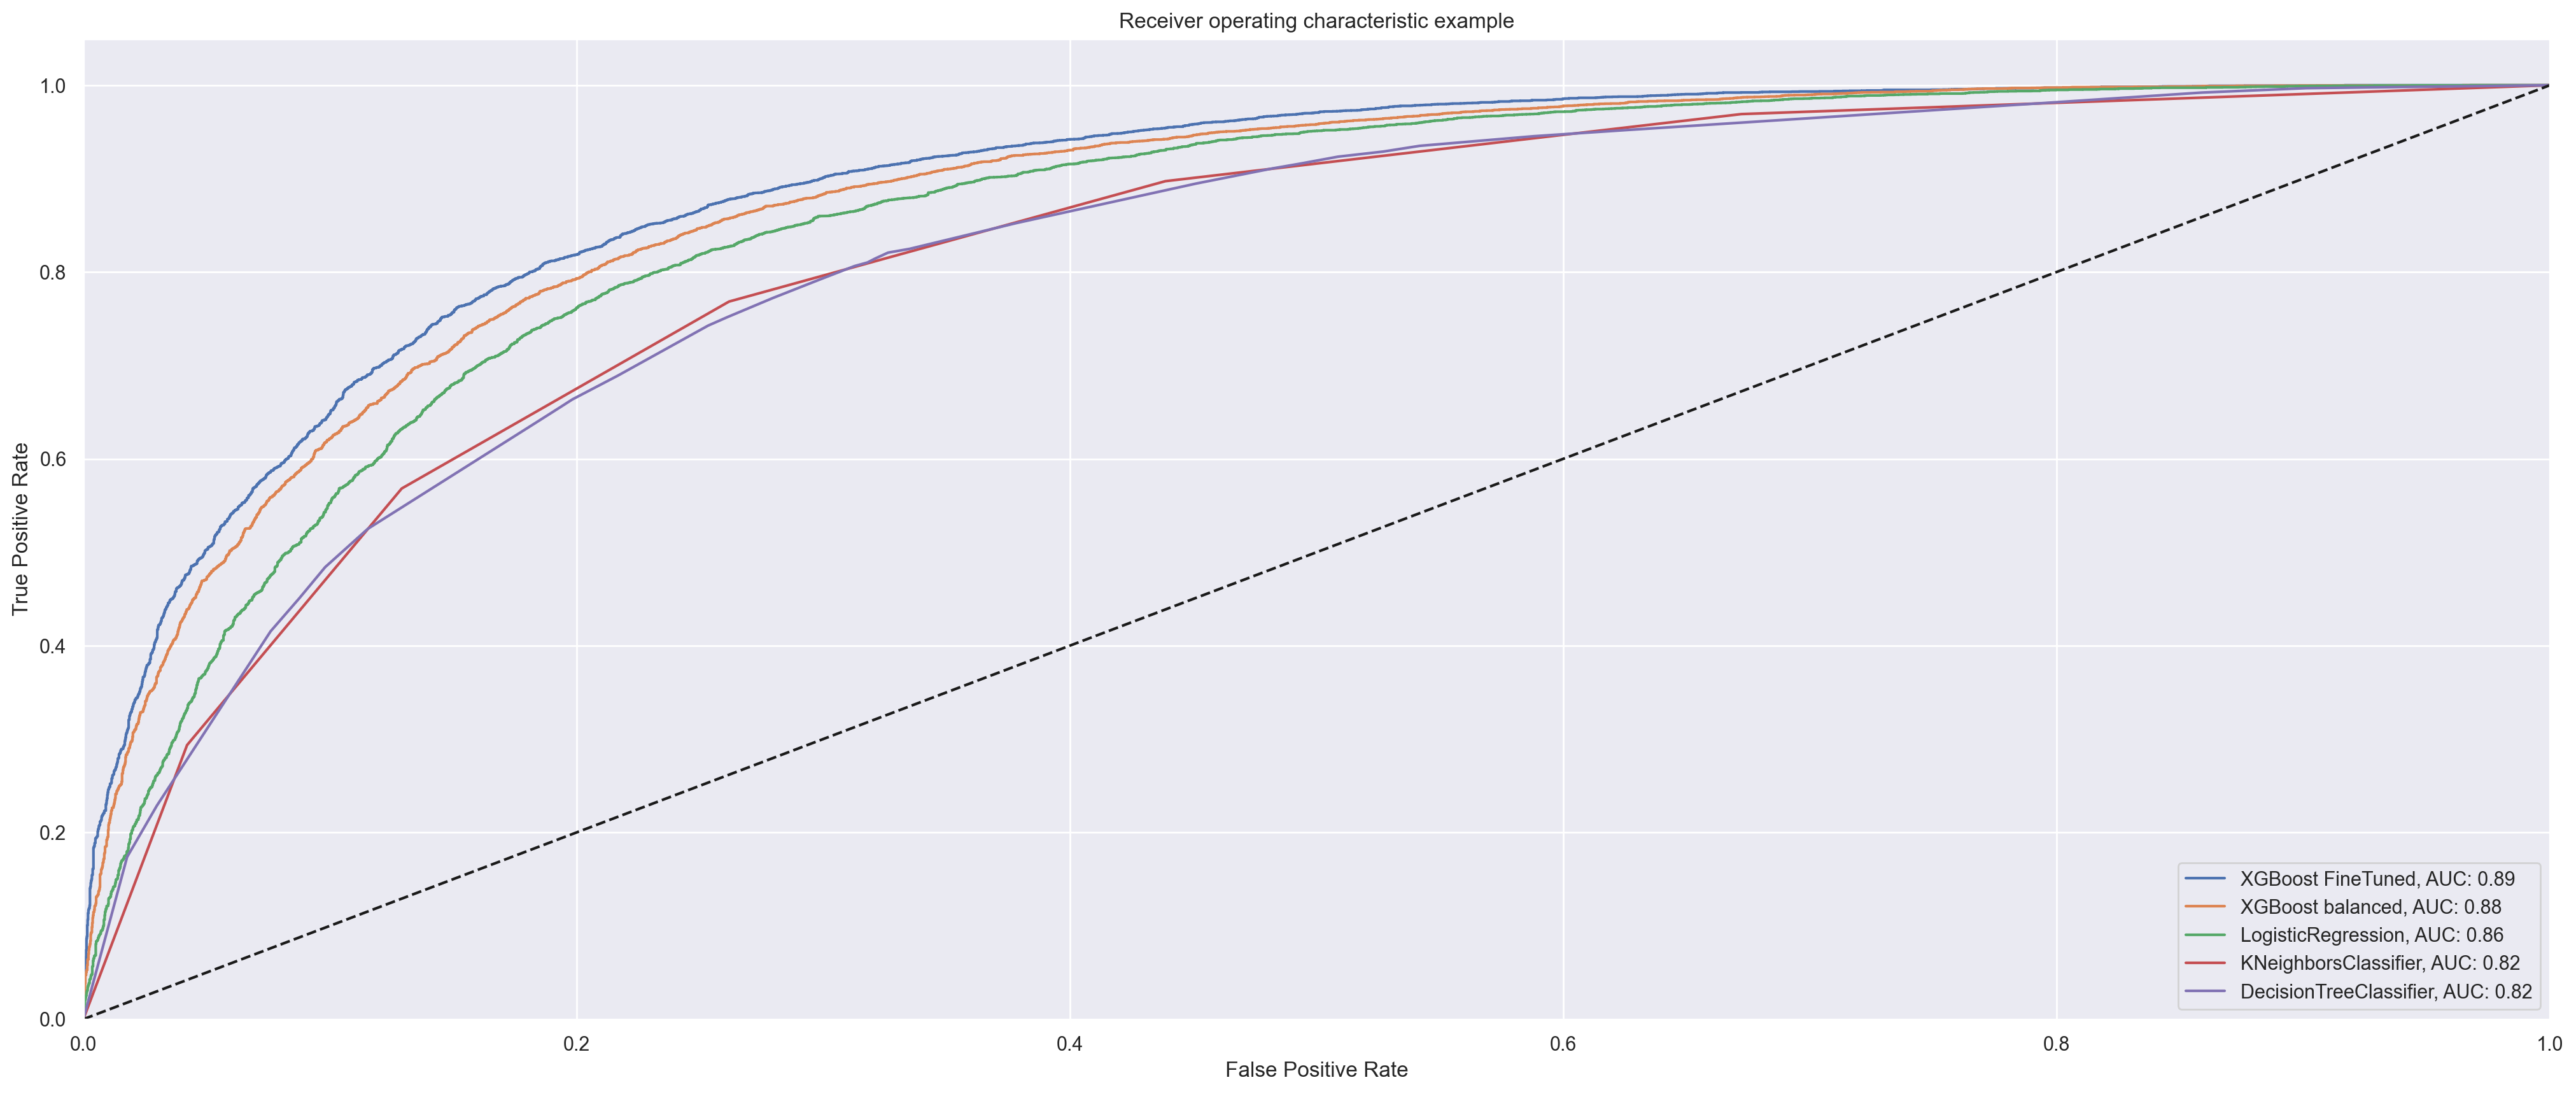

In [30]:
# Fine tuned model
xg_fpr, xg_tpr, _ = roc_curve(y_test, final_cl.predict_proba(X_test_processed)[:,1])
AUC = auc(xg_fpr, xg_tpr)
plt.plot(xg_fpr, xg_tpr, label="%s, AUC: %.2f" % ("XGBoost FineTuned", AUC))

# Balanced model with xgboost
xg_fpr, xg_tpr, _ = roc_curve(y_test, xgb_cl.predict_proba(X_test_processed)[:,1])
AUC = auc(xg_fpr, xg_tpr)
plt.plot(xg_fpr, xg_tpr, label="%s, AUC: %.2f" % ("XGBoost balanced", AUC))

# Logistic regression (as a comparison model)
lr = LogisticRegression(solver="lbfgs", max_iter=1000)
lr.fit(X_train_processed, y_train.reshape(-1,))
xg_fpr, xg_tpr, _ = roc_curve(y_test, lr.predict_proba(X_test_processed)[:,1])
AUC = auc(xg_fpr, xg_tpr)
plt.plot(xg_fpr, xg_tpr, label="%s, AUC: %.2f" % (type(lr).__name__, AUC))

# Knn (as a comparison model)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_processed, y_train.reshape(-1,))
xg_fpr, xg_tpr, _ = roc_curve(y_test, knn.predict_proba(X_test_processed)[:,1])
AUC = auc(xg_fpr, xg_tpr)
plt.plot(xg_fpr, xg_tpr, label="%s, AUC: %.2f" % (type(knn).__name__, AUC))

# Decision tree (as a comparison model)
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train_processed, y_train.reshape(-1,))
xg_fpr, xg_tpr, _ = roc_curve(y_test, dt.predict_proba(X_test_processed)[:,1])
AUC = auc(xg_fpr, xg_tpr)
plt.plot(xg_fpr, xg_tpr, label="%s, AUC: %.2f" % (type(dt).__name__, AUC))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
#plt.savefig('roc_curves.png')
plt.show()

#### Feature importance with XGBoost

In addition XGBoost provides a way to examine the importance of each feature in the original dataset within the model. It involves counting the number of times each feature is split on across all boosting trees in the model. Then we visualize the result as a bar graph, with the features ordered according to how many times they appear.

XGBoost has a plot_importance() function that helps us to achieve this task. Then we can visualize the features that has been given the highest important score among all the features. Thus XGBoost provides us a way to do feature selection.

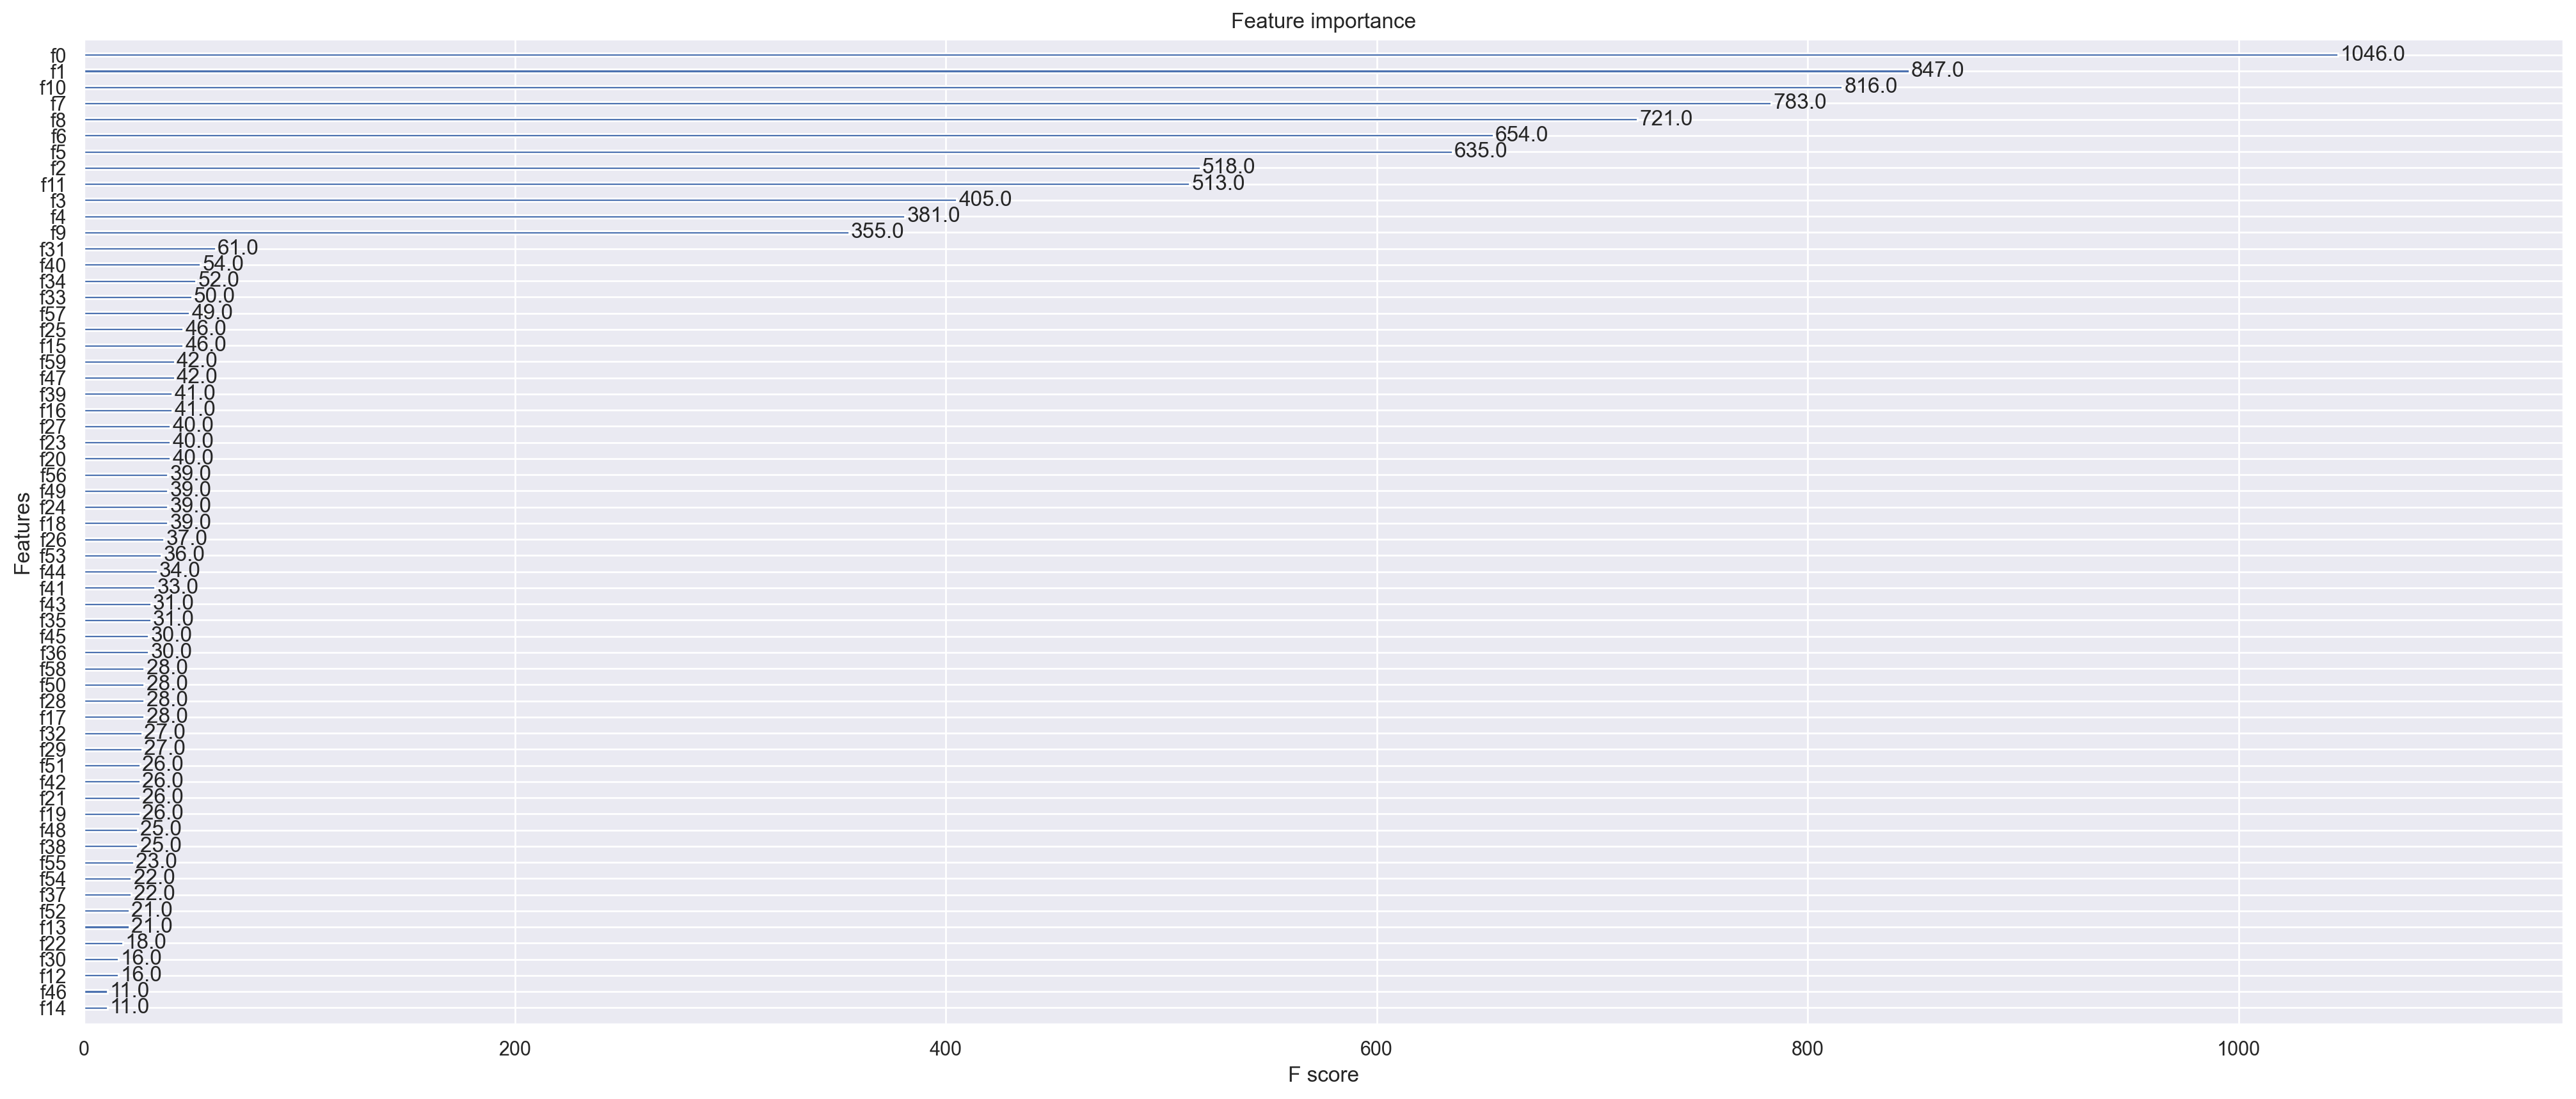

In [31]:
xgb.plot_importance(xgb_cl); # Plot feature importance

We need to track back the map of the feature engineering in order to give significance to "f0", etc, but we have a plot indicating which features are more important in our dataset.